In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"achmadfauzannabil","key":"6f9e7aee51e86f68151fb3d8ff867f43"}'}

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

kaggle.json


In [5]:
!kaggle datasets download -d anandhuh/population-data-india

  0% 0.00/2.58k [00:00<?, ?B/s]
100% 2.58k/2.58k [00:00<00:00, 4.66MB/s]


In [6]:
!mkdir population-data-india
!unzip population-data-india.zip -d population-data-india
!ls population-data-india

mkdir: cannot create directory ‘population-data-india’: File exists
Archive:  population-data-india.zip
  inflating: population-data-india/india_population.csv  
  inflating: population-data-india/india_population_forecast.csv  
  inflating: population-data-india/population_indian_cities.csv  
india_population.csv  india_population_forecast.csv  population_indian_cities.csv


# deskripsi library yang digunakan

In [7]:
import pandas as pd
import numpy as np

# library untuk lvisualisasi
import matplotlib.pyplot as plt
import seaborn as sns

# library untuk analisis time series
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# library yang digunakan untuk forecasting
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# memanggil dataset

In [41]:
df = pd.read_csv('/content/population-data-india/india_population.csv')

# deskripsi dataset

In [42]:
df.head()

,Year,Population,Yearly % Change,Yearly Change,Migrants (net),Median Age,Fertility Rate,Density (P/Km²),Urban Pop %,Urban Population,Country's Share of World Pop,World Population,India Global Rank
0,2020,1380004385,0.99,13586631,-532687,28.4,2.24,464,35.0,483098640,17.70,7794798739,2
1,2019,1366417754,1.02,13775474,-532687,27.1,2.36,460,34.5,471828295,17.71,7713468100,2
2,2018,1352642280,1.04,13965495,-532687,27.1,2.36,455,34.1,460779764,17.73,7631091040,2
3,2017,1338676785,1.07,14159536,-532687,27.1,2.36,450,33.6,449963381,17.74,7547858925,2
4,2016,1324517249,1.10,14364846,-532687,27.1,2.36,445,33.2,439391699,17.75,7464022049,2


In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18 entries, 0 to 17
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Year                          18 non-null     int64  
 1   Population                    18 non-null     int64  
 2   Yearly % Change               18 non-null     float64
 3   Yearly Change                 18 non-null     int64  
 4   Migrants (net)                18 non-null     int64  
 5   Median Age                    18 non-null     float64
 6   Fertility Rate                18 non-null     float64
 7   Density (P/Km²)               18 non-null     int64  
 8   Urban Pop %                   18 non-null     float64
 9   Urban Population              18 non-null     int64  
 10  Country's Share of World Pop  18 non-null     float64
 11  World Population              18 non-null     int64  
 12  India Global Rank             18 non-null     int64  
dtypes: floa

In [44]:
df.columns

Index(['Year', 'Population', 'Yearly % Change', 'Yearly Change',
       'Migrants (net)', 'Median Age', 'Fertility Rate', 'Density (P/Km²)',
       'Urban Pop %', 'Urban Population', 'Country's Share of World Pop',
       'World Population', 'India Global Rank'],
      dtype='object')

In [45]:
df = df.drop(['Yearly % Change', 'Yearly Change','Migrants (net)', 'Median Age',
              'Fertility Rate', 'Density (P/Km²)','Urban Pop %', 'Urban Population',
              "Country's Share of World Pop",'World Population', 'India Global Rank'], axis=1)

In [46]:
df.head()

,Year,Population
0,2020,1380004385
1,2019,1366417754
2,2018,1352642280
3,2017,1338676785
4,2016,1324517249


# transform data

In [47]:
df['Year'] = pd.to_datetime(df['Year'], format='%Y')

In [48]:
df.set_index(['Year'], inplace=True)

In [49]:
df.head()

,Population
Year,
2020-01-01,1380004385
2019-01-01,1366417754
2018-01-01,1352642280
2017-01-01,1338676785
2016-01-01,1324517249


In [50]:
df.index.min(), df.index.max()

(Timestamp('1955-01-01 00:00:00'), Timestamp('2020-01-01 00:00:00'))

In [51]:
df = df.resample('Y').sum()

In [52]:
df.shape

(66, 1)

# analisa time series

<Axes: xlabel='Year'>

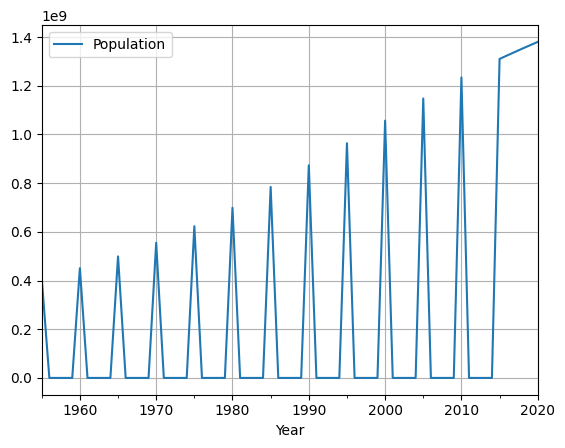

In [53]:
df.plot(grid=True)

In [56]:
train_df = df.iloc[:50]
test_df = df.iloc[51:]

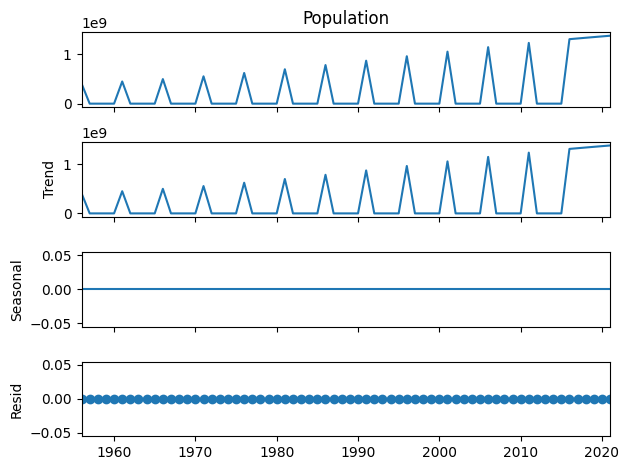

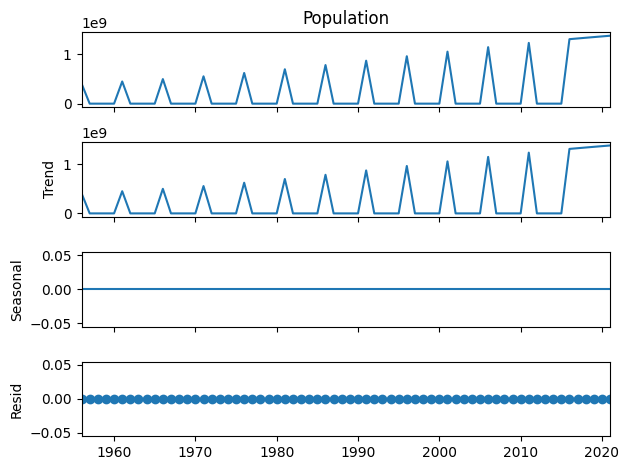

In [57]:
decompose_add = seasonal_decompose(df['Population'])
decompose_add.plot()

In [58]:
def adf_test(timeseries):
    print ('Hasil testing Dickey-Fuller')
    print ('----------------------------------')
    adftest = adfuller(timeseries)
    adf_output = pd.Series(adftest[0:4], index=['Test statistic','p-value','Lags Used','Number of Observation Used'])
    for key, Value in adftest[4].items() :
        adf_output['Critical Value (%s)' %key] = Value
    print (adf_output)

adf_test(df.values)

Hasil testing Dickey-Fuller
----------------------------------
Test statistic                 4.647544
p-value                        1.000000
Lags Used                     10.000000
Number of Observation Used    55.000000
Critical Value (1%)           -3.555273
Critical Value (5%)           -2.915731
Critical Value (10%)          -2.595670
dtype: float64


In [59]:
diff_df = df.diff()
diff_df.head()

,Population
Year,
1955-12-31,NaN
1956-12-31,-409880595.0
1957-12-31,0.0
1958-12-31,0.0
1959-12-31,0.0


In [60]:
diff_df.dropna(inplace=True)

<Axes: xlabel='Year'>

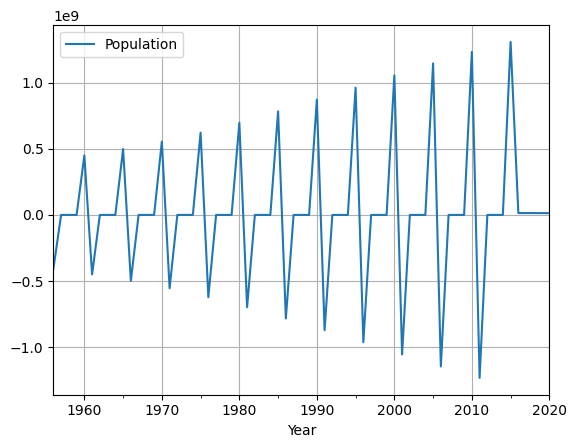

In [61]:
diff_df.plot(grid=True)

In [62]:
adf_test(diff_df)

Hasil testing Dickey-Fuller
----------------------------------
Test statistic                 0.029226
p-value                        0.960883
Lags Used                     11.000000
Number of Observation Used    53.000000
Critical Value (1%)           -3.560242
Critical Value (5%)           -2.917850
Critical Value (10%)          -2.596796
dtype: float64


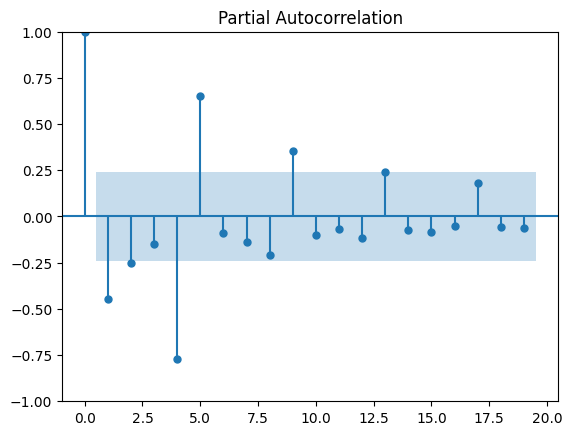

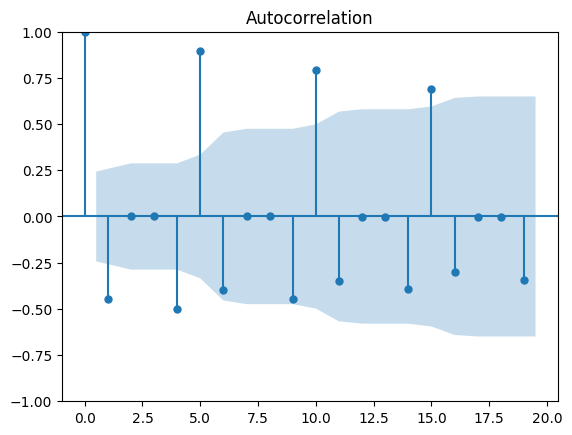

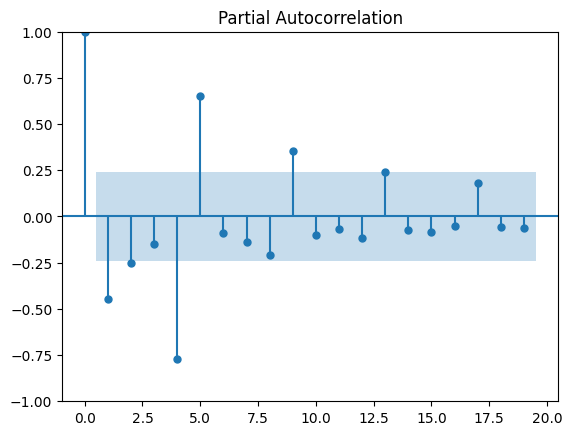

In [63]:
plot_acf(diff_df)
plot_pacf(diff_df)

In [66]:
df.shape

(66, 1)

# Single Exponential Smoothing

In [86]:
single_exp = SimpleExpSmoothing(train_df).fit()
single_exp_train_pred = single_exp.fittedvalues
single_exp_test_pred = single_exp.forecast(15)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


<Axes: xlabel='Year'>

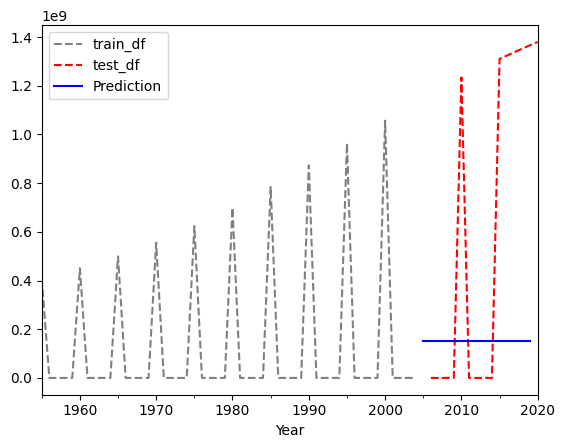

In [87]:
train_df['Population'].plot(style='--', color='gray', legend=True, label='train_df')
test_df['Population'].plot(style='--', color='r', legend=True, label='test_df')
single_exp_test_pred.plot(color='b', legend=True, label='Prediction')

In [88]:
Train_RMSE_SES = mean_squared_error(train_df, single_exp_train_pred)**0.5
Test_RMSE_SES = mean_squared_error(test_df, single_exp_test_pred)**0.5
Train_MAPE_SES = mean_absolute_percentage_error(train_df, single_exp_train_pred)
Test_MAPE_SES = mean_absolute_percentage_error(test_df, single_exp_test_pred)

print('Train RMSE :',Train_RMSE_SES)
print('Test RMSE :', Test_RMSE_SES)
print('Train MAPE :', Train_MAPE_SES)
print('Test MAPE :', Test_MAPE_SES)

Train RMSE : 320453411.9592464
Test RMSE : 812873731.388359
Train MAPE : 7.038215074382666e+23
Test MAPE : 3.6395949304555325e+23


# ARIMA

In [89]:
ar = ARIMA(train_df, order=(15,1,15)).fit()
ar_train_pred = ar.fittedvalues
ar_test_pred = ar.forecast(15)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<Axes: xlabel='Year'>

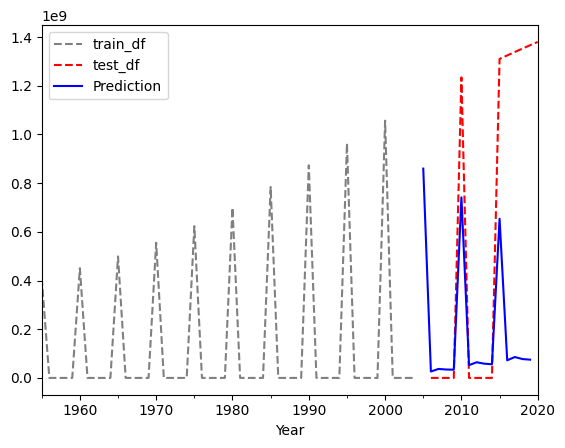

In [90]:
train_df['Population'].plot(style='--', color='gray', legend=True, label='train_df')
test_df['Population'].plot(style='--', color='r', legend=True, label='test_df')
ar_test_pred.plot(color='b', legend=True, label='Prediction')

In [91]:
Train_RMSE_AR = mean_squared_error(train_df, ar_train_pred)**0.5
Test_RMSE_AR = mean_squared_error(test_df, ar_test_pred)**0.5
Train_MAPE_AR = mean_absolute_percentage_error(train_df, ar_train_pred)
Test_MAPE_AR = mean_absolute_percentage_error(test_df, ar_test_pred)

print('Train RMSE :',Train_RMSE_AR)
print('Test RMSE :', Test_RMSE_AR)
print('Train MAPE :', Train_MAPE_AR)
print('Test MAPE :', Test_MAPE_AR)

Train RMSE : 116132410.34184496
Test RMSE : 869433547.2106411
Train MAPE : 1.6624039948213573e+23
Test MAPE : 5.627361926236723e+23


# perbandingan Algoritma

In [104]:
comparision_df = pd.DataFrame(data=[
    ['Single Exp Smoothing', Test_RMSE_SES, Test_MAPE_SES],
    ['ARIMA', Test_RMSE_AR, Test_MAPE_AR]
    ],
    columns=['Model','RMSE','MAPE'])
comparision_df.set_index('Model', inplace=True)

In [105]:
comparision_df.sort_values(by='RMSE')

,RMSE,MAPE
Model,,
Single Exp Smoothing,8.128737e+08,3.639595e+23
ARIMA,8.694335e+08,5.627362e+23


In [106]:
single_exp = SimpleExpSmoothing(df).fit()
single_exp_test_pred = single_exp.forecast(15)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


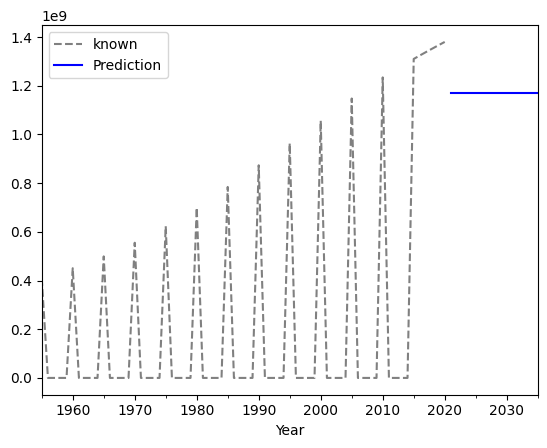

In [107]:
df['Population'].plot(style='--', color='gray', legend=True, label='known')
single_exp_test_pred.plot(color='b', legend=True, label='Prediction')
plt.show()

In [108]:
import pickle

In [109]:
pickle.dump(single_exp, open('prediksi_Population.sav','wb'))